In [60]:
import pyspark

In [61]:
from pyspark.sql import SparkSession

In [62]:
Spark = SparkSession.builder.appName('practice').getOrCreate()

In [63]:
Spark

In [64]:
column_names = ['HCHO Reading', 'Location', 'Current Date', 'Next Date']
data_frame = Spark.read.csv('C:/Users/MSI KATANA/Desktop/practice ML/data engineering cw by inupa B/Data-Engineering-HCHO-gas-prediction-/col_mat_nuw_output.csv', header=None, inferSchema=True)
# Assign column names
data_frame = data_frame.toDF(*column_names)

# Show the DataFrame
data_frame.show()


+--------------------+--------------+------------+----------+
|        HCHO Reading|      Location|Current Date| Next Date|
+--------------------+--------------+------------+----------+
|1.969834395781014...|Colombo Proper|  2019-01-01|2019-01-02|
|2.625522171968594...|Colombo Proper|  2019-01-02|2019-01-03|
|9.852118897938794E-5|Colombo Proper|  2019-01-03|2019-01-04|
|2.099320518114242E-4|Colombo Proper|  2019-01-04|2019-01-05|
|1.785337298892930...|Colombo Proper|  2019-01-05|2019-01-06|
|1.082296700235670...|Colombo Proper|  2019-01-06|2019-01-07|
|3.926829280477309...|Colombo Proper|  2019-01-07|2019-01-08|
|9.153156350685351E-5|Colombo Proper|  2019-01-08|2019-01-09|
|1.205978992853015...|Colombo Proper|  2019-01-09|2019-01-10|
|1.297723562983258...|Colombo Proper|  2019-01-10|2019-01-11|
|2.239188166801278...|Colombo Proper|  2019-01-11|2019-01-12|
|1.569418094178759...|Colombo Proper|  2019-01-12|2019-01-13|
|                NULL|Colombo Proper|  2019-01-13|2019-01-14|
|1.33629

In [65]:
# Assuming data_frame is your DataFrame

# Get the number of rows
num_rows = data_frame.count()

# Get the number of columns
num_columns = len(data_frame.columns)

# Print the shape
print("Shape of the DataFrame: {} rows, {} columns".format(num_rows, num_columns))


Shape of the DataFrame: 5478 rows, 4 columns


In [66]:
data_frame.printSchema()

root
 |-- HCHO Reading: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- Current Date: date (nullable = true)
 |-- Next Date: date (nullable = true)



In [67]:
from pyspark.sql.functions import col, sum as spark_sum, when

columns = data_frame.columns

# Calculate missing values for each column
missing_counts = data_frame.select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in columns])

# Show missing counts
missing_counts.show()

+------------+--------+------------+---------+
|HCHO Reading|Location|Current Date|Next Date|
+------------+--------+------------+---------+
|        2419|       0|           0|        0|
+------------+--------+------------+---------+



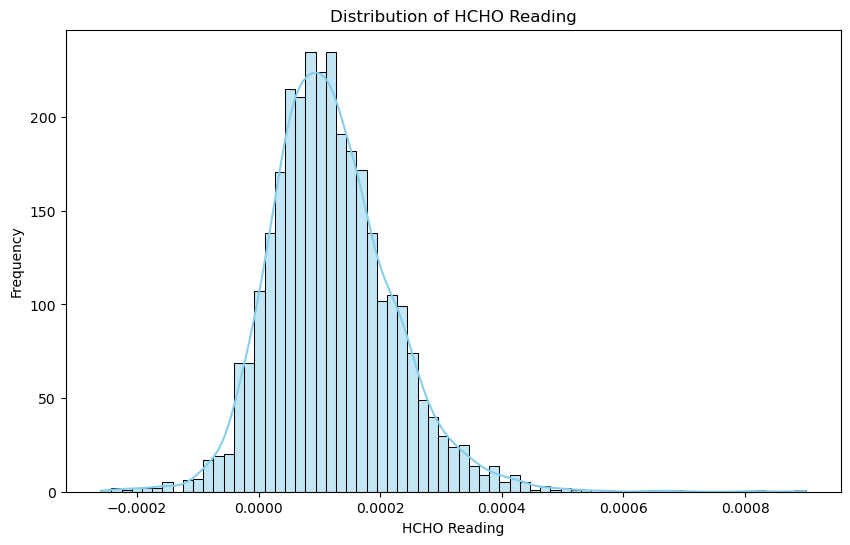

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the "HCHO Reading" column to a Pandas DataFrame for visualization
hcho_df = data_frame.select("HCHO Reading").toPandas()

# Plot the distribution of the "HCHO Reading" column
plt.figure(figsize=(10, 6))
sns.histplot(hcho_df["HCHO Reading"], kde=True, color='skyblue')
plt.title('Distribution of HCHO Reading')
plt.xlabel('HCHO Reading')
plt.ylabel('Frequency')
plt.show()


In [69]:
from pyspark.sql.window import Window
from pyspark.sql.functions import coalesce, col, lag, lead, count

# Initialize a counter for null values
null_count = data_frame.filter(col("HCHO Reading").isNull()).count()

# Continue the process until there are no nulls left
while null_count > 0:
    # Define the window specifications
    backward_windowSpec = Window.orderBy("Current Date")
    forward_windowSpec = Window.orderBy("Current Date")
    
    # Use lag to carry the last observation forward
    previous_value = lag("HCHO Reading", 1).over(backward_windowSpec)
    data_frame = data_frame.withColumn("HCHO Reading", coalesce("HCHO Reading", previous_value))
    
    # Use lead to carry the next observation backward
    next_value = lead("HCHO Reading", 1).over(forward_windowSpec)
    data_frame = data_frame.withColumn("HCHO Reading", coalesce("HCHO Reading", next_value))
    
    # Update the null count
    null_count = data_frame.filter(col("HCHO Reading").isNull()).count()

# cmn_data now has the nulls filled using a combination of LOCF and NOCB

In [70]:
from pyspark.sql.functions import col, sum as spark_sum, when

columns = data_frame.columns

# Calculate missing values for each column
missing_counts = data_frame.select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in columns])

# Show missing counts
missing_counts.show()

+------------+--------+------------+---------+
|HCHO Reading|Location|Current Date|Next Date|
+------------+--------+------------+---------+
|           0|       0|           0|        0|
+------------+--------+------------+---------+



In [71]:
data_frame.show()

+--------------------+-------------------+------------+----------+
|        HCHO Reading|           Location|Current Date| Next Date|
+--------------------+-------------------+------------+----------+
|1.969834395781014...|     Colombo Proper|  2019-01-01|2019-01-02|
|1.969834395781014...|   Deniyaya, Matara|  2019-01-01|2019-01-02|
|2.625522171968594...|Nuwara Eliya Proper|  2019-01-01|2019-01-02|
|2.625522171968594...|     Colombo Proper|  2019-01-02|2019-01-03|
|5.803530712000793E-6|   Deniyaya, Matara|  2019-01-02|2019-01-03|
|5.803530712000793E-6|Nuwara Eliya Proper|  2019-01-02|2019-01-03|
|9.852118897938794E-5|     Colombo Proper|  2019-01-03|2019-01-04|
|2.362357772653922...|   Deniyaya, Matara|  2019-01-03|2019-01-04|
|1.908293886956784...|Nuwara Eliya Proper|  2019-01-03|2019-01-04|
|2.099320518114242E-4|     Colombo Proper|  2019-01-04|2019-01-05|
|6.437245753953118E-5|   Deniyaya, Matara|  2019-01-04|2019-01-05|
|5.097625917127737...|Nuwara Eliya Proper|  2019-01-04|2019-01

In [74]:
pandas_df_1 = data_frame.toPandas()
pandas_df_1

,HCHO Reading,Location,Current Date,Next Date
0,0.000197,Colombo Proper,2019-01-01,2019-01-02
1,0.000197,"Deniyaya, Matara",2019-01-01,2019-01-02
2,0.000263,Nuwara Eliya Proper,2019-01-01,2019-01-02
3,0.000263,Colombo Proper,2019-01-02,2019-01-03
4,0.000006,"Deniyaya, Matara",2019-01-02,2019-01-03
...,...,...,...,...
5473,0.000116,"Deniyaya, Matara",2023-12-30,2023-12-31
5474,0.000116,Nuwara Eliya Proper,2023-12-30,2023-12-31
5475,0.000080,Colombo Proper,2023-12-31,2024-01-01
5476,0.000080,"Deniyaya, Matara",2023-12-31,2024-01-01


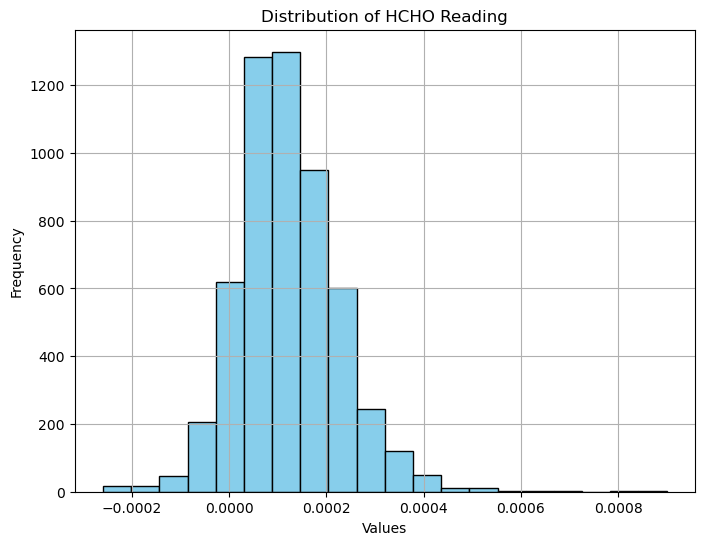

In [79]:
import matplotlib.pyplot as plt

# Assuming pandas_df_1 is your Pandas DataFrame

# Selecting the feature "HCHO Reading"
feature = "HCHO Reading"

# Plot histogram for the selected feature
plt.figure(figsize=(8, 6))
plt.hist(pandas_df_1[feature], bins=20, color='skyblue', edgecolor='black')
plt.title(f'Distribution of {feature}')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


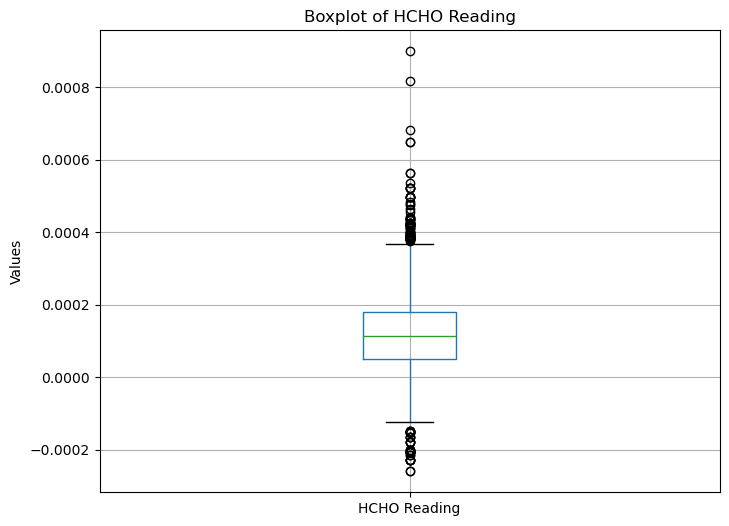

In [78]:
import matplotlib.pyplot as plt

feature = "HCHO Reading"

# Plot boxplot for the selected feature
plt.figure(figsize=(8, 6))
pandas_df_1.boxplot(column=[feature])
plt.title(f'Boxplot of {feature}')
plt.ylabel('Values')
plt.show()


In [80]:
import numpy as np

# Assuming pandas_df_1 is your Pandas DataFrame and feature is "HCHO Reading"

# Extracting the HCHO readings
hcho_readings = pandas_df_1[feature]

# Calculating quartiles and IQR
Q1 = hcho_readings.quantile(0.25)
Q3 = hcho_readings.quantile(0.75)
IQR = Q3 - Q1

# Defining outlier thresholds
lower_threshold = Q1 - 1.5 * IQR
upper_threshold = Q3 + 1.5 * IQR

# Counting outliers
outliers_frequency = ((hcho_readings < lower_threshold) | (hcho_readings > upper_threshold)).sum()

print("Frequency of outliers:", outliers_frequency)


Frequency of outliers: 112


In [81]:
# Define the Winsorization function
def winsorize(series, lower_threshold, upper_threshold):
    # Winsorize the series
    winsorized_series = series.clip(lower=lower_threshold, upper=upper_threshold)
    return winsorized_series

# Apply Winsorization to handle outliers
pandas_df_1[feature] = winsorize(pandas_df_1[feature], lower_threshold, upper_threshold)

# Recalculate the frequency of outliers after Winsorization
outliers_after_winsorization = ((pandas_df_1[feature] < lower_threshold) | (pandas_df_1[feature] > upper_threshold)).sum()

print("Frequency of outliers after Winsorization:", outliers_after_winsorization)


Frequency of outliers after Winsorization: 0


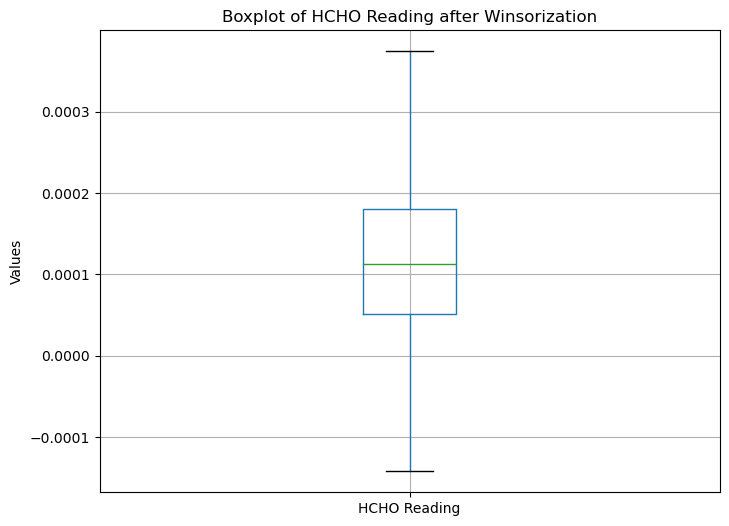

In [82]:
import matplotlib.pyplot as plt

# Plot boxplot for the Winsorized feature
plt.figure(figsize=(8, 6))
pandas_df_1.boxplot(column=[feature])
plt.title(f'Boxplot of {feature} after Winsorization')
plt.ylabel('Values')
plt.show()


# Importing second dataset Kandy

In [46]:
column_names_2 = ['HCHO Reading', 'Location', 'Current Date', 'Next Date']
data_frame = Spark.read.csv('C:/Users/MSI KATANA/Desktop/practice ML/data engineering cw by inupa B/Data-Engineering-HCHO-gas-prediction-/kan_output.csv', header=None, inferSchema=True)
# Assign column names
data_frame_2 = data_frame.toDF(*column_names_2)

# Show the DataFrame
data_frame_2.show()

+--------------------+------------+------------+----------+
|        HCHO Reading|    Location|Current Date| Next Date|
+--------------------+------------+------------+----------+
|1.760713459877335...|Kandy Proper|  2019-01-01|2019-01-02|
|9.220391253917748E-5|Kandy Proper|  2019-01-02|2019-01-03|
|                NULL|Kandy Proper|  2019-01-03|2019-01-04|
|1.908681983853839...|Kandy Proper|  2019-01-04|2019-01-05|
|1.219517840206744...|Kandy Proper|  2019-01-05|2019-01-06|
|-6.51408612938880...|Kandy Proper|  2019-01-06|2019-01-07|
|  1.6323820639265E-4|Kandy Proper|  2019-01-07|2019-01-08|
|-6.73520553391426...|Kandy Proper|  2019-01-08|2019-01-09|
|1.279693658243135...|Kandy Proper|  2019-01-09|2019-01-10|
|4.546048424126012E-5|Kandy Proper|  2019-01-10|2019-01-11|
|3.600074175192105E-5|Kandy Proper|  2019-01-11|2019-01-12|
|1.286629698010177E-4|Kandy Proper|  2019-01-12|2019-01-13|
|                NULL|Kandy Proper|  2019-01-13|2019-01-14|
|                NULL|Kandy Proper|  201

In [47]:
# Get the number of rows
num_rows = data_frame_2.count()

# Get the number of columns
num_columns = len(data_frame_2.columns)

# Print the shape
print("Shape of the DataFrame: {} rows, {} columns".format(num_rows, num_columns))

Shape of the DataFrame: 1826 rows, 4 columns


In [48]:
data_frame_2.printSchema()

root
 |-- HCHO Reading: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- Current Date: date (nullable = true)
 |-- Next Date: date (nullable = true)



In [49]:
from pyspark.sql.functions import col, sum as spark_sum, when

columns = data_frame_2.columns

# Calculate missing values for each column
missing_counts = data_frame_2.select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in columns])

# Show missing counts
missing_counts.show()

+------------+--------+------------+---------+
|HCHO Reading|Location|Current Date|Next Date|
+------------+--------+------------+---------+
|         793|       0|           0|        0|
+------------+--------+------------+---------+



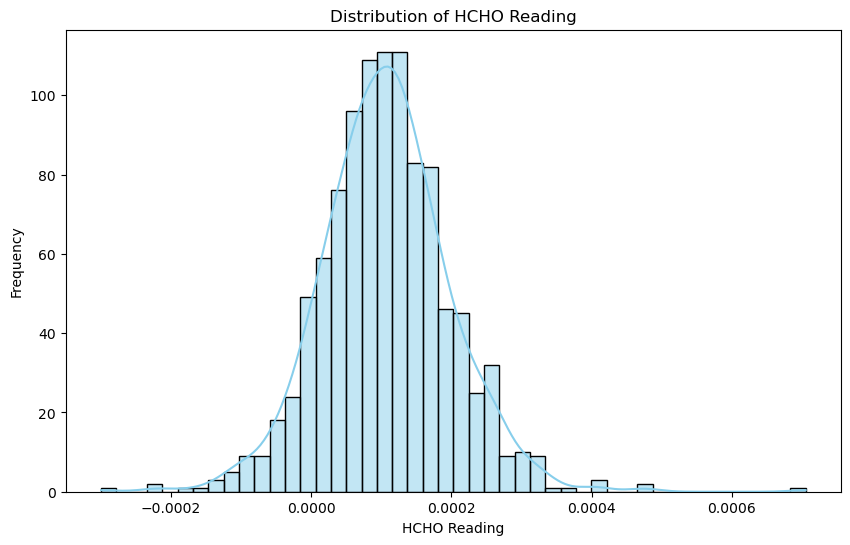

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the "HCHO Reading" column to a Pandas DataFrame for visualization
hcho_df_2 = data_frame_2.select("HCHO Reading").toPandas()

# Plot the distribution of the "HCHO Reading" column
plt.figure(figsize=(10, 6))
sns.histplot(hcho_df_2 ["HCHO Reading"], kde=True, color='skyblue')
plt.title('Distribution of HCHO Reading')
plt.xlabel('HCHO Reading')
plt.ylabel('Frequency')
plt.show()


In [51]:
from pyspark.sql.window import Window
from pyspark.sql.functions import coalesce, col, lag, lead, count

# Initialize a counter for null values
null_count_2 = data_frame_2.filter(col("HCHO Reading").isNull()).count()

# Continue the process until there are no nulls left
while null_count_2 > 0:
    # Define the window specifications
    backward_windowSpec = Window.orderBy("Current Date")
    forward_windowSpec = Window.orderBy("Current Date")
    
    # Use lag to carry the last observation forward
    previous_value = lag("HCHO Reading", 1).over(backward_windowSpec)
    data_frame_2 = data_frame_2.withColumn("HCHO Reading", coalesce("HCHO Reading", previous_value))
    
    # Use lead to carry the next observation backward
    next_value = lead("HCHO Reading", 1).over(forward_windowSpec)
    data_frame_2 = data_frame_2.withColumn("HCHO Reading", coalesce("HCHO Reading", next_value))
    
    # Update the null count
    null_count_2 = data_frame_2.filter(col("HCHO Reading").isNull()).count()

# cmn_data now has the nulls filled using a combination of LOCF and NOCB

In [52]:
from pyspark.sql.functions import col, sum as spark_sum, when

columns_2 = data_frame_2.columns

# Calculate missing values for each column
missing_counts_2 = data_frame_2.select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in columns_2])

# Show missing counts
missing_counts_2.show()

+------------+--------+------------+---------+
|HCHO Reading|Location|Current Date|Next Date|
+------------+--------+------------+---------+
|           0|       0|           0|        0|
+------------+--------+------------+---------+



In [88]:
pandas_df_2 = data_frame_2.toPandas()
pandas_df_2

,HCHO Reading,Location,Current Date,Next Date
0,0.000176,Kandy Proper,2019-01-01,2019-01-02
1,0.000092,Kandy Proper,2019-01-02,2019-01-03
2,0.000092,Kandy Proper,2019-01-03,2019-01-04
3,0.000191,Kandy Proper,2019-01-04,2019-01-05
4,0.000122,Kandy Proper,2019-01-05,2019-01-06
...,...,...,...,...
1821,0.000056,Kandy Proper,2023-12-27,2023-12-28
1822,0.000056,Kandy Proper,2023-12-28,2023-12-29
1823,0.000056,Kandy Proper,2023-12-29,2023-12-30
1824,0.000056,Kandy Proper,2023-12-30,2023-12-31


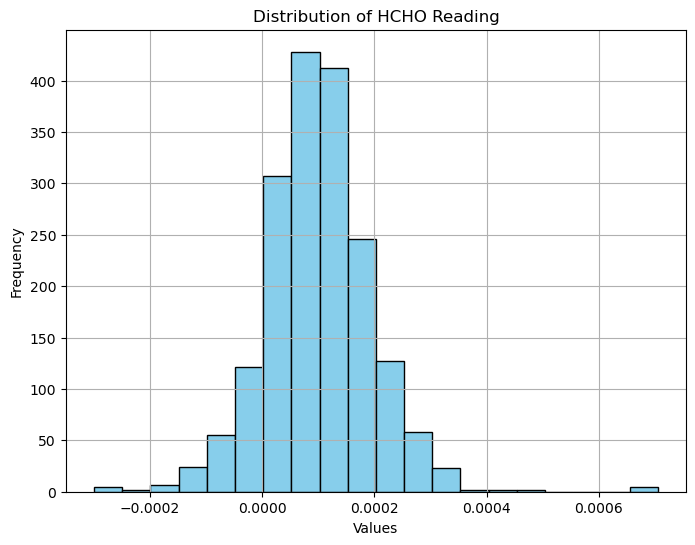

In [89]:
import matplotlib.pyplot as plt

# Assuming pandas_df_1 is your Pandas DataFrame

# Selecting the feature "HCHO Reading"
feature_2 = "HCHO Reading"

# Plot histogram for the selected feature
plt.figure(figsize=(8, 6))
plt.hist(pandas_df_2[feature_2], bins=20, color='skyblue', edgecolor='black')
plt.title(f'Distribution of {feature}')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

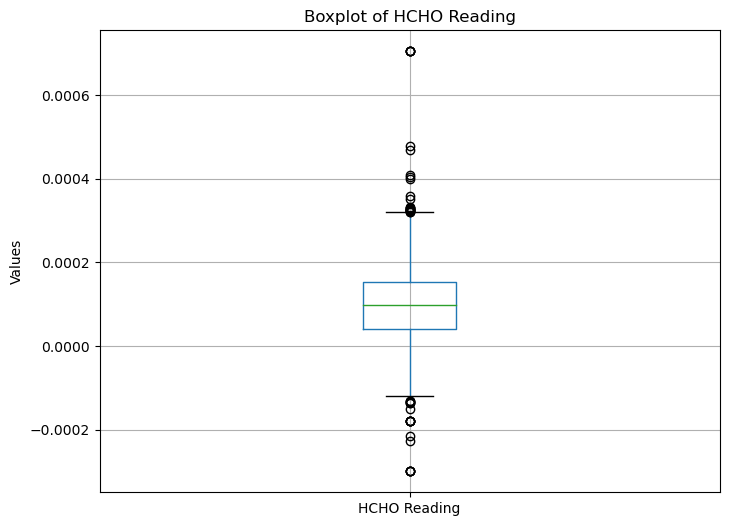

In [90]:
import matplotlib.pyplot as plt

feature_2 = "HCHO Reading"

# Plot boxplot for the selected feature
plt.figure(figsize=(8, 6))
pandas_df_2.boxplot(column=[feature_2])
plt.title(f'Boxplot of {feature}')
plt.ylabel('Values')
plt.show()

In [91]:
# Extracting the HCHO readings from pandas_df_2
hcho_readings_2 = pandas_df_2[feature_2]

# Calculating quartiles and IQR
Q1_2 = hcho_readings_2.quantile(0.25)
Q3_2 = hcho_readings_2.quantile(0.75)
IQR_2 = Q3_2 - Q1_2

# Defining outlier thresholds
lower_threshold_2 = Q1_2 - 1.5 * IQR_2
upper_threshold_2 = Q3_2 + 1.5 * IQR_2

# Counting outliers
outliers_frequency_2 = ((hcho_readings_2 < lower_threshold_2) | (hcho_readings_2 > upper_threshold_2)).sum()

print("Frequency of outliers in feature_2:", outliers_frequency_2)



Frequency of outliers in feature_2: 45


In [92]:
# Define the Winsorization function
def winsorize(series, lower_threshold, upper_threshold):
    # Winsorize the series
    winsorized_series = series.clip(lower=lower_threshold, upper=upper_threshold)
    return winsorized_series

# Apply Winsorization to handle outliers
pandas_df_2[feature_2] = winsorize(pandas_df_2[feature_2], lower_threshold_2, upper_threshold_2)

# Recalculate the frequency of outliers after Winsorization
outliers_after_winsorization_2 = ((pandas_df_2[feature_2] < lower_threshold_2) | (pandas_df_2[feature_2] > upper_threshold_2)).sum()

print("Frequency of outliers after Winsorization in feature_2:", outliers_after_winsorization_2)


Frequency of outliers after Winsorization in feature_2: 0


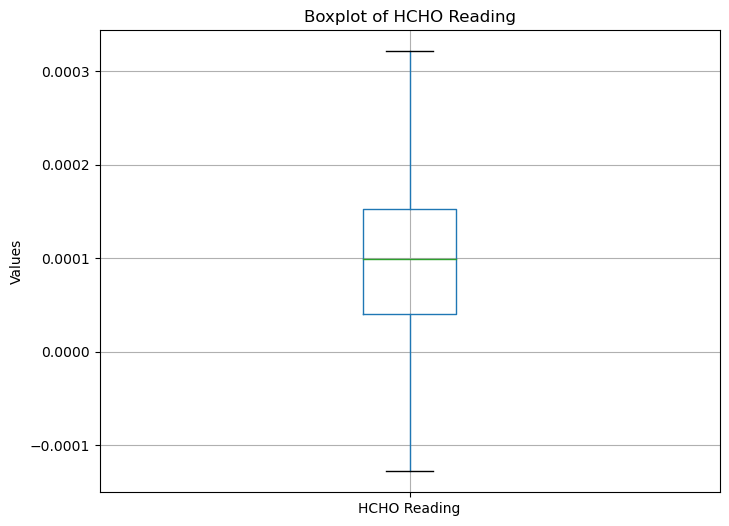

In [93]:
import matplotlib.pyplot as plt

feature_2 = "HCHO Reading"

# Plot boxplot for the selected feature
plt.figure(figsize=(8, 6))
pandas_df_2.boxplot(column=[feature_2])
plt.title(f'Boxplot of {feature}')
plt.ylabel('Values')
plt.show()

# Importing third dataset

In [53]:
column_names_3 = ['HCHO Reading', 'Location', 'Current Date', 'Next Date']
data_frame_3 = Spark.read.csv('C:/Users/MSI KATANA/Desktop/practice ML/data engineering cw by inupa B/Data-Engineering-HCHO-gas-prediction-/mon_kur_jaf_output.csv', header=None, inferSchema=True)
# Assign column names
data_frame_3 = data_frame_3.toDF(*column_names_3)

# Show the DataFrame
data_frame_3.show()

+--------------------+------------------+------------+----------+
|        HCHO Reading|          Location|Current Date| Next Date|
+--------------------+------------------+------------+----------+
|                NULL|Bibile, Monaragala|  2019-01-01|2019-01-02|
|1.919914652467399E-5|Bibile, Monaragala|  2019-01-02|2019-01-03|
|2.811447935930283...|Bibile, Monaragala|  2019-01-03|2019-01-04|
|3.747998184385943E-5|Bibile, Monaragala|  2019-01-04|2019-01-05|
|-1.79826087934531...|Bibile, Monaragala|  2019-01-05|2019-01-06|
|1.457836896179902...|Bibile, Monaragala|  2019-01-06|2019-01-07|
|2.828590802546534...|Bibile, Monaragala|  2019-01-07|2019-01-08|
|                NULL|Bibile, Monaragala|  2019-01-08|2019-01-09|
|1.420850167050957...|Bibile, Monaragala|  2019-01-09|2019-01-10|
|                NULL|Bibile, Monaragala|  2019-01-10|2019-01-11|
|2.014587947072581E-5|Bibile, Monaragala|  2019-01-11|2019-01-12|
|1.582787663210183...|Bibile, Monaragala|  2019-01-12|2019-01-13|
|         

In [54]:
# Get the number of rows
num_rows = data_frame_3.count()

# Get the number of columns
num_columns = len(data_frame_3.columns)

# Print the shape
print("Shape of the DataFrame: {} rows, {} columns".format(num_rows, num_columns))

Shape of the DataFrame: 5478 rows, 4 columns


In [55]:
from pyspark.sql.functions import col, sum as spark_sum, when

columns = data_frame_3.columns

# Calculate missing values for each column
missing_counts = data_frame_3.select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in columns])

# Show missing counts
missing_counts.show()

+------------+--------+------------+---------+
|HCHO Reading|Location|Current Date|Next Date|
+------------+--------+------------+---------+
|        1652|       0|           0|        0|
+------------+--------+------------+---------+



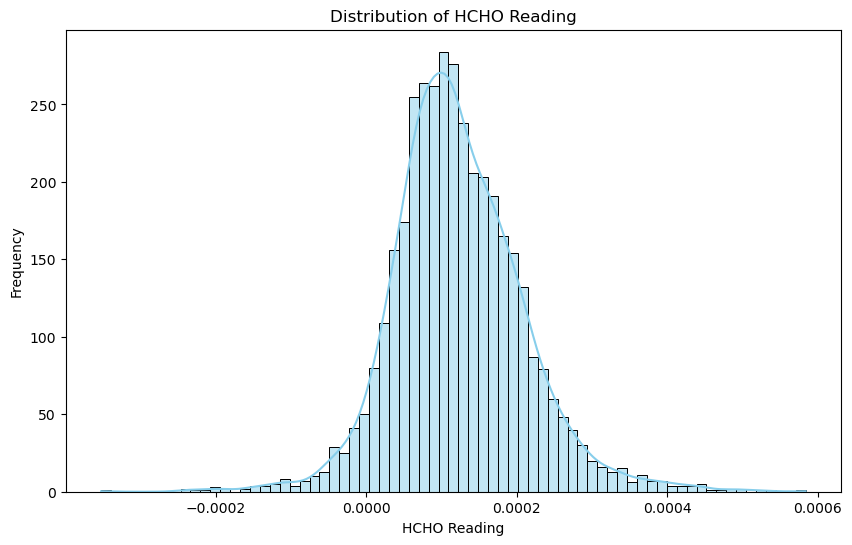

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the "HCHO Reading" column to a Pandas DataFrame for visualization
hcho_df_3 = data_frame_3.select("HCHO Reading").toPandas()

# Plot the distribution of the "HCHO Reading" column
plt.figure(figsize=(10, 6))
sns.histplot(hcho_df_3["HCHO Reading"], kde=True, color='skyblue')
plt.title('Distribution of HCHO Reading')
plt.xlabel('HCHO Reading')
plt.ylabel('Frequency')
plt.show()

In [57]:
from pyspark.sql.window import Window
from pyspark.sql.functions import coalesce, col, lag, lead, count

# Initialize a counter for null values
null_count_3 = data_frame_3.filter(col("HCHO Reading").isNull()).count()

# Continue the process until there are no nulls left
while null_count_3 > 0:
    # Define the window specifications
    backward_windowSpec = Window.orderBy("Current Date")
    forward_windowSpec = Window.orderBy("Current Date")
    
    # Use lag to carry the last observation forward
    previous_value = lag("HCHO Reading", 1).over(backward_windowSpec)
    data_frame_3 = data_frame_3.withColumn("HCHO Reading", coalesce("HCHO Reading", previous_value))
    
    # Use lead to carry the next observation backward
    next_value = lead("HCHO Reading", 1).over(forward_windowSpec)
    data_frame_3 = data_frame_3.withColumn("HCHO Reading", coalesce("HCHO Reading", next_value))
    
    # Update the null count
    null_count_3 = data_frame_3.filter(col("HCHO Reading").isNull()).count()

# cmn_data now has the nulls filled using a combination of LOCF and NOCB

In [58]:
from pyspark.sql.functions import col, sum as spark_sum, when

columns_3 = data_frame_3.columns

# Calculate missing values for each column
missing_counts_3 = data_frame_3.select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in columns_3])

# Show missing counts
missing_counts_3.show()

+------------+--------+------------+---------+
|HCHO Reading|Location|Current Date|Next Date|
+------------+--------+------------+---------+
|           0|       0|           0|        0|
+------------+--------+------------+---------+



In [94]:
pandas_df_3 = data_frame_3.toPandas()
pandas_df_3

,HCHO Reading,Location,Current Date,Next Date
0,0.000088,"Bibile, Monaragala",2019-01-01,2019-01-02
1,0.000088,Kurunegala Proper,2019-01-01,2019-01-02
2,0.000058,Jaffna Proper,2019-01-01,2019-01-02
3,0.000019,"Bibile, Monaragala",2019-01-02,2019-01-03
4,0.000137,Kurunegala Proper,2019-01-02,2019-01-03
...,...,...,...,...
5473,0.000158,Kurunegala Proper,2023-12-30,2023-12-31
5474,0.000117,Jaffna Proper,2023-12-30,2023-12-31
5475,0.000117,"Bibile, Monaragala",2023-12-31,2024-01-01
5476,0.000065,Kurunegala Proper,2023-12-31,2024-01-01


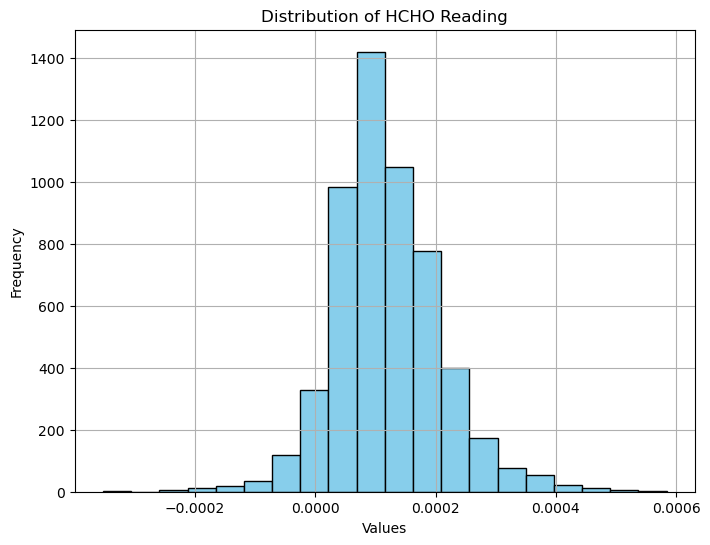

In [96]:
import matplotlib.pyplot as plt

# Selecting the feature "HCHO Reading"
feature_3 = "HCHO Reading"

# Plot histogram for the selected feature
plt.figure(figsize=(8, 6))
plt.hist(pandas_df_3[feature_3], bins=20, color='skyblue', edgecolor='black')
plt.title(f'Distribution of {feature}')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

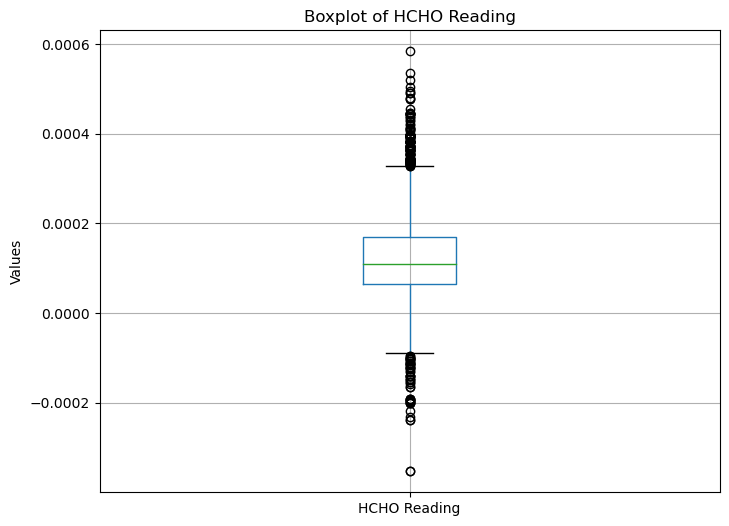

In [97]:
import matplotlib.pyplot as plt

feature_3 = "HCHO Reading"

# Plot boxplot for the selected feature
plt.figure(figsize=(8, 6))
pandas_df_3.boxplot(column=[feature_3])
plt.title(f'Boxplot of {feature}')
plt.ylabel('Values')
plt.show()

In [98]:
# Extracting the HCHO readings from pandas_df_3
hcho_readings_3 = pandas_df_3[feature_3]

# Calculating quartiles and IQR
Q1_3 = hcho_readings_3.quantile(0.25)
Q3_3 = hcho_readings_3.quantile(0.75)
IQR_3 = Q3_3 - Q1_3

# Defining outlier thresholds
lower_threshold_3 = Q1_3 - 1.5 * IQR_3
upper_threshold_3 = Q3_3 + 1.5 * IQR_3

# Counting outliers
outliers_frequency_3 = ((hcho_readings_3 < lower_threshold_3) | (hcho_readings_3 > upper_threshold_3)).sum()

print("Frequency of outliers in feature_3:", outliers_frequency_3)


Frequency of outliers in feature_3: 179


In [99]:
# Define the Winsorization function
def winsorize(series, lower_threshold, upper_threshold):
    # Winsorize the series
    winsorized_series = series.clip(lower=lower_threshold, upper=upper_threshold)
    return winsorized_series

# Apply Winsorization to handle outliers
pandas_df_3[feature_3] = winsorize(pandas_df_3[feature_3], lower_threshold_3, upper_threshold_3)

# Recalculate the frequency of outliers after Winsorization
outliers_after_winsorization_3 = ((pandas_df_3[feature_3] < lower_threshold_3) | (pandas_df_3[feature_3] > upper_threshold_3)).sum()

print("Frequency of outliers after Winsorization in feature_3:", outliers_after_winsorization_3)


Frequency of outliers after Winsorization in feature_3: 0


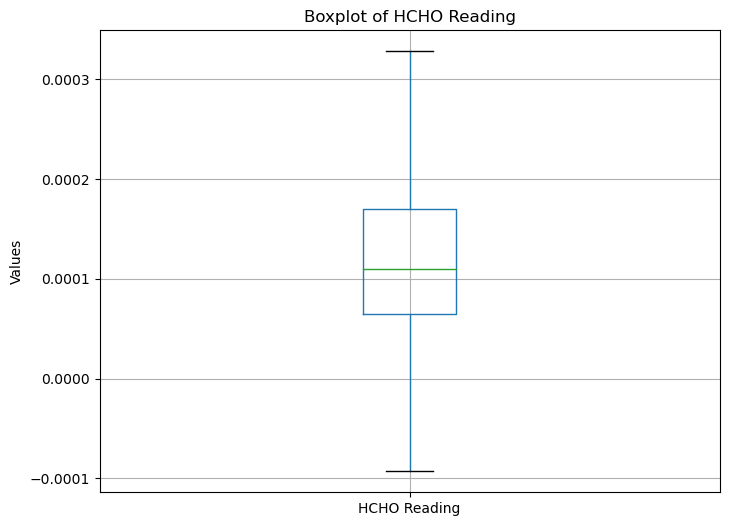

In [100]:
import matplotlib.pyplot as plt

feature_3 = "HCHO Reading"

# Plot boxplot for the selected feature
plt.figure(figsize=(8, 6))
pandas_df_3.boxplot(column=[feature_3])
plt.title(f'Boxplot of {feature}')
plt.ylabel('Values')
plt.show()

In [101]:
pandas_df_3

,HCHO Reading,Location,Current Date,Next Date
0,0.000088,"Bibile, Monaragala",2019-01-01,2019-01-02
1,0.000088,Kurunegala Proper,2019-01-01,2019-01-02
2,0.000058,Jaffna Proper,2019-01-01,2019-01-02
3,0.000019,"Bibile, Monaragala",2019-01-02,2019-01-03
4,0.000137,Kurunegala Proper,2019-01-02,2019-01-03
...,...,...,...,...
5473,0.000158,Kurunegala Proper,2023-12-30,2023-12-31
5474,0.000117,Jaffna Proper,2023-12-30,2023-12-31
5475,0.000117,"Bibile, Monaragala",2023-12-31,2024-01-01
5476,0.000065,Kurunegala Proper,2023-12-31,2024-01-01
